# Treinamento do Modelo Indoor x Outdoor
Luana Barros




In [0]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
import pandas as pd
import librosa
import librosa.display
import os
from os import path
import io
!pip3 install soundfile
!pip3 install librosa
import soundfile as sf
import librosa.feature


In [0]:
!pip install ipython-autotime

%load_ext autotime

Dataset de nomes e labels de todas as músicas, disponibilizado pelo DCASE



In [6]:
DIR = '/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class' 
DIR_AUDIO = DIR + '/soundfiles/TAU-urban-acoustic-scenes-2020-3class-development/'
df_meta = pd.read_csv(f'{DIR}/meta.csv')
df_meta = pd.read_csv(io.StringIO(df_meta.to_csv(index=False)))
df_meta.head()

,filename,scene_label,identifier
0,audio/airport-barcelona-0-0-a.wav,indoor,barcelona-0
1,audio/airport-barcelona-0-10-a.wav,indoor,barcelona-0
2,audio/airport-barcelona-0-11-a.wav,indoor,barcelona-0
3,audio/airport-barcelona-0-12-a.wav,indoor,barcelona-0
4,audio/airport-barcelona-0-13-a.wav,indoor,barcelona-0


time: 1.32 s


In [7]:
df_meta.values.shape

(14400, 3)

time: 4.44 ms


In [8]:
df_meta = df_meta[df_meta['scene_label'] != 'transportation']

time: 3.98 ms


In [9]:
print(df_meta.loc[df_meta['scene_label'] == 'outdoor'].shape)
print(df_meta.loc[df_meta['scene_label'] == 'indoor'].shape)
print(df_meta.loc[df_meta['scene_label'] == 'transportation'].shape)

(5760, 3)
(4320, 3)
(0, 3)
time: 8.62 ms


Reading the datasets and storing it to 'signals'

In [10]:
info_sound = df_meta[['filename','scene_label']].to_numpy()
np.unique(info_sound).shape

(10082,)

time: 15.1 ms


In [12]:
FILEPATH = '/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/features.csv'
BASE_PATH = '/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/'

time: 753 µs


Labels:


0.   Indoor
1.   Outdoor



Função que calcula as features de uma única música, dividindo o sinal em 10 partes e salva no final de um dataframe de features lido posteriormente

In [32]:
PARTS = 10
def get_features(filename, signal, label)->pd.DataFrame:
    def get_centroid(y, sr):
        return librosa.feature.spectral_centroid(y=y, sr=sr)
    def get_flatness(y):
        return librosa.feature.spectral_flatness(y=y)
    def get_rms(y):
        return librosa.feature.rms(y=y)
    def get_mfccs(y, sr):
        return librosa.feature.mfcc(y=y, sr=sr, n_mfcc=5)

    feats = (np.zeros((1,18))[0])
    
    music_features = []
    signal = signal[:,0]
    for second in np.array_split(signal, PARTS):
        arr_mfcc = []
        c = get_centroid(second, SAMPLERATE)
        f = get_flatness(second)
        rms = get_rms(second)
        mfccs = get_mfccs(second, SAMPLERATE)
        mfccs_mean = [np.mean(x) for x in mfccs]
        mfccs_std = [np.std(x) for x in mfccs]
        music_features = np.hstack([arr_mfcc, np.array([np.mean(c),np.std(c),np.mean(f), np.std(f),np.mean(rms),np.std(rms)]), mfccs_mean, mfccs_std, filename, label]) 
        feats = np.vstack([feats, music_features])     
    return pd.DataFrame(data=feats).drop(0).reset_index(drop=True)

time: 13.9 ms


Função que importa o sinal de áudio e calcula as features (Deixo comentado pq já estão calculadas)




In [37]:
'''for filename, label in info_sound:
    if(path.isfile(os.path.join(DIR_AUDIO, filename))):
        signal, sr = sf.read(os.path.join(DIR_AUDIO, filename))
        signal = signal - np.mean(signal)
        signal = signal / np.std(signal)
        feats = get_features(filename, signal, label)
        if (create_new): 
            feats.to_csv(FILEPATH, mode='w', header=True, index=False)
            create_new = False
        else:
            feats.to_csv(FILEPATH, mode='a', header=False, index=False)'''

"for filename, label in info_sound:\n    if(path.isfile(os.path.join(DIR_AUDIO, filename))):\n        signal, sr = sf.read(os.path.join(DIR_AUDIO, filename))\n        signal = signal - np.mean(signal)\n        signal = signal / np.std(signal)\n        feats = get_features(filename, signal, label)\n        if (create_new): \n            feats.to_csv(FILEPATH, mode='w', header=True, index=False)\n            create_new = False\n        else:\n            feats.to_csv(FILEPATH, mode='a', header=False, index=False)"

time: 2.78 ms


# Reading Features Dataframe

DF: Descrição

        features
*   0: média centroide 
*   1: std centroide
*   2: media flatness
*   3: std flatness
*   4: média rms
*   5: std rms
*   6-10: media mfccs
*   11-15: std mfccs


        outros
*   16: name
*   17: label






In [17]:
df = pd.read_csv(FILEPATH)
df.values.shape

(144000, 18)

time: 3.15 s


Exclui as amostras que são transportation

In [18]:
df = df[df['17'] != 'transportation']
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,2067.077543,314.596949,0.001208,0.000796,0.832156,0.190869,-6.301599,162.615785,-0.669503,21.995021,16.196891,11.842684,11.356795,9.448871,8.314006,6.413742,audio/airport-barcelona-0-0-a.wav,indoor
1,2396.326648,837.458722,0.002880,0.004073,1.048020,0.297459,28.847755,164.139732,-10.588623,11.819030,18.117304,23.760919,22.448040,15.889869,7.593259,8.504107,audio/airport-barcelona-0-0-a.wav,indoor
2,2135.928400,951.601138,0.002351,0.006495,1.104539,0.239383,27.343979,172.183293,-4.441265,12.758123,14.174672,15.299824,18.721131,10.422640,8.023112,6.574066,audio/airport-barcelona-0-0-a.wav,indoor
3,3452.822655,2038.634637,0.009708,0.018092,0.855968,0.179588,40.054581,139.243859,0.369508,16.225708,10.133507,45.845526,31.659113,15.694926,12.090027,11.095558,audio/airport-barcelona-0-0-a.wav,indoor
4,2306.117659,400.394482,0.002110,0.001465,0.695591,0.141256,-1.595393,158.681146,-3.881455,22.452005,18.370355,26.562323,11.427413,10.013492,8.081751,7.794196,audio/airport-barcelona-0-0-a.wav,indoor


time: 55.5 ms


In [19]:
#df.iloc[:,-1], indices = pd.factorize(df.iloc[:,-1])

time: 665 µs


In [21]:
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import pickle
from collections import Counter
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.model_selection import train_test_split

time: 33.8 ms


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Split no dataframe df_meta, selecionando músicas de teste e treino

In [33]:
def split_train_test(df, df_meta):
    filename, label = df_meta['filename'].values, df_meta['scene_label'].values
    train_names, test_names, train_labels, test_labels = train_test_split(filename, label, test_size=0.2,random_state=42)
    #pickle.dump(train_names, open("train_names.pkl", "wb"))
    #pickle.dump(test_names, open("test_names.pkl", "wb"))
    
    X_train = df.loc[df['16'].isin(train_names)]
    X_test = df.loc[df['16'].isin(test_names)]
    y_train = X_train[['16', '17']]
    y_test = X_test[['16', '17']]
    X_train = X_train.drop(columns=['16','17'])
    X_test = X_test.drop(columns=['16','17'])
    return [X_train, X_test, y_train, y_test]

time: 6.12 ms


In [23]:
def standardize(X_train, X_test):
    scaler = StandardScaler()
    scaler.fit(X_train.values)
    joblib.dump(scaler, BASE_PATH + 'scaler_io.pkl')
    X_train = scaler.transform(X_train.values)
    X_test = scaler.transform(X_test.values)
    return [X_train, X_test]

time: 68.4 ms


# Linear SVC Classifier

In [34]:
from sklearn.metrics import confusion_matrix,classification_report, plot_confusion_matrix, accuracy_score, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.externals import joblib
from sklearn.svm import LinearSVC

time: 1.82 ms


In [25]:
def get_model(X_train,y_train, y_test, X_test):
    model = LinearSVC(C=10, random_state=42)
    model.fit(X_train,y_train)
    y_pred = (model.predict(X_test))
    print("SVC Accuracy :", accuracy_score(y_test, y_pred))
    filename = BASE_PATH + 'linearsvc_indoor_outdoor.pkl'
    #joblib.dump(model, filename)
    return model, y_pred

time: 4.15 ms


In [26]:
def plot_cf(y_pred, y_test):
    print(classification_report(y_test, y_pred))

time: 878 µs


Contagem das predições para cada música

In [35]:
def contagem_e_votacao(test_vs_pred):
    '''
        Cria um dicionário com os nomes das músicas e adiciona todas as 10 predições associadas a uma música
    '''
    dic_names = dict()
    music_names_unique = np.unique(test_vs_pred['16'])
    for id in music_names_unique:
        dic_names[id] = []
    #print(len(dic_names))

    for name, label, pred in test_vs_pred.values:
        #print(name, label, pred)
        dic_names[name].append(pred)

    '''
        Utiliza um counter para contar a frequência dos labels (indoor ou outdoor)
        Depois pega o label com maior contagem para ser o label definitivo
    '''
    counter = [Counter(pred) for name,pred in dic_names.items()]
    music_y_pred = [max(x, key=x.get) for x in counter]
    #print(music_y_pred)
    #print(len(music_y_pred))
    music_y_test = (test_vs_pred[['16','17']].drop_duplicates())['17'].values
    #print((music_y_test))
    plot_cf(music_y_pred, music_y_test)
    return metrics.accuracy_score(music_y_test,music_y_pred)

time: 8.99 ms


In [28]:
def pca(X_train, X_test, y_train, y_test):
    pca = PCA(2)
    scl = StandardScaler()
    X = np.vstack([X_train,X_test])
    y = np.hstack([y_train,y_test])
    X_scl = scl.fit_transform(X)
    pca.fit(X_scl)
    X_pca = pca.transform(X_scl)
    sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1],hue=y)

time: 3.93 ms


In [29]:
def classify(df, df_meta):
    X_train, X_test, y_train, y_test = split_train_test(df,df_meta) 
    X_train, X_test = standardize(X_train, X_test)
    model, y_pred = get_model(X_train, y_train['17'].values, y_test['17'].values, X_test)
    test_vs_pred = y_test
    test_vs_pred['pred'] = y_pred
    final_accuracy = contagem_e_votacao(test_vs_pred)
    pca(X_train, X_test, y_train['17'].values, y_test['17'].values)
    return final_accuracy

time: 7.67 ms


/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


SVC Accuracy : 0.7540178571428572
LinearSVC(C=10, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
          verbose=0)
              precision    recall  f1-score   support

      indoor       0.72      0.80      0.76       845
     outdoor       0.85      0.77      0.81      1171

    accuracy                           0.79      2016
   macro avg       0.78      0.79      0.78      2016
weighted avg       0.79      0.79      0.79      2016

0.7857142857142857


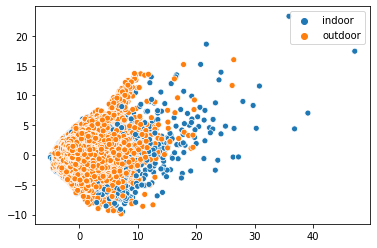

time: 17.5 s


In [36]:
acc = classify(df, df_meta)
print(acc)

Tamanho do modelo em KB

In [31]:
(os.path.getsize(BASE_PATH + 'linearsvc_indoor_outdoor.pkl')/1024)

1.1416015625

time: 5.07 ms
